<a href="https://colab.research.google.com/github/ragibayon/Coursera_Capstone/blob/master/Capstone_The_Battle_of_the_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to suggest an optimal location for buying an appartment. Specifically, this report will be targeted to stakeholders interested in byuying  an **realstate** in **Dhaka Division**, Bangladesh.

Since there are lots of areas in Dhaka we will try to detect **locations that are included only in Dhaka district**. We are also particularly interested in **areas with restaurants and malls in vicinity**. We would also prefer locations **as close to public transportation as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* numbers of existing venues in the neighborhood (any type of venues)
* number of and distance to public transport in the neighborhood, if any
* distance of neighborhood from resturents and shopping malls

We decided to use the Sub-Office of postal service, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* The neighbourhood location will be determined by using **Geopy**
* number of venues and their type and location in every neighborhood will be obtained using **Foursquare API**

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. First we need to scrape the Dhaka district's neighbourhood locations and data from this [link](https://en.wikipedia.org/wiki/List_of_postal_codes_in_Bangladesh) and then find the latitude & longitude of the neighborhoods, using specific, well known address and geopy.

**Import necessary Libraries**

In [98]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
from pandas import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

import folium # map rendering library
from bs4 import BeautifulSoup # for web scraping
import lxml
print('Libraries imported.')

Libraries imported.


Web Scrape for obtainging neighourhoods of Dhaka division, Bangladesh.

In [0]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_in_Bangladesh'
List_of_postal_codes_in_Bangladesh_request=requests.get(url).text
List_of_postal_codes_in_Bangladesh_html=BeautifulSoup(List_of_postal_codes_in_Bangladesh_request,'html.parser')
List_of_postal_codes_in_Bangladesh_tables=List_of_postal_codes_in_Bangladesh_html.find_all('table',class_="wikitable")
len(List_of_postal_codes_in_Bangladesh_tables) # 8 tables for 8 divisions
Dhaka_division_table=List_of_postal_codes_in_Bangladesh_tables[0] # Dhaka Division

The ***Dhaka_division_table*** contains the required table in HTML format. we need to extract the table and make a Pandas dataframe for further utilizing and modifying it. These fuctions stated bellow will convert ythe html format into pd dataframe

In [0]:
def get_table_headers(table):
    """Given a table soup, returns all the headers"""
    headers = []
    for th in table.find("tr").find_all("th"):
        headers.append(th.text.strip())
    return headers

def get_table_rows(table):
    """Given a table, returns all its rows"""
    rows = []
    for tr in table.find_all("tr")[1:]:
        cells = []
        # grab all td tags in this table row
        tds = tr.find_all("td")
        if len(tds) == 0:
            # if no td tags, search for th tags
            # can be found especially in wikipedia tables below the table
            ths = tr.find_all("th")
            for th in ths:
                cells.append(th.text.strip())
        else:
            # use regular td tags
            for td in tds:
                cells.append(td.text.strip())
        rows.append(cells)
    return rows

In [0]:
headers=get_table_headers(Dhaka_division_table)
rows=get_table_rows(Dhaka_division_table)

Dhaka_division_postcode=pd.DataFrame(rows,columns=headers)
Dhaka_division_postcode=Dhaka_division_postcode.rename(columns={'Post Code[1]':'Post Code'})
Dhaka_district_postcode=Dhaka_division_postcode[Dhaka_division_postcode['District']=='Dhaka']

Now let's find the Latitude and Longitude of these areas so that we can extract nearby venues from Forsqure API. The following function will return a location data frame with neighborhood name and its geo graphical location

In [0]:
def get_location(Thana,Post_code):
    lat=[]
    long=[]
    Pcode=[]
    geolocator = Nominatim(user_agent="to_explorer",timeout=5)
    for Thana, Post_code in zip(Thana,
                                Post_code):
        address = '{}, Dhaka {} , Bangladesh'.format(Thana,Post_code)
        location = geolocator.geocode(address)
        print(location)
        if location==None:
            latitude = np.nan
            longitude = np.nan
        else:
            latitude = location.latitude
            longitude = location.longitude
        
        lat.append(latitude)
        long.append(longitude)
        Pcode.append(Post_code)
    location_df=pd.DataFrame({'Latitude': lat,'Longitude': long, 'Post Code':Pcode})
    return location_df

In [28]:
location_df=get_location(Thana=Dhaka_district_postcode['Thana'],
                         Post_code=Dhaka_district_postcode['Post Code'])

ঢাকা জেলা, ঢাকা বিভাগ, Bangladesh
ধামরাই, ধামরাই উপজেলা, ঢাকা জেলা, ঢাকা বিভাগ, 1350, Bangladesh
ধানমন্ডি আ/এ, ঢাকা, ঢাকা জেলা, ঢাকা বিভাগ, Bangladesh
গুলশান, ঢাকা, ঢাকা জেলা, ঢাকা বিভাগ, Bangladesh
গুলশান, ঢাকা, ঢাকা জেলা, ঢাকা বিভাগ, Bangladesh
গুলশান, ঢাকা, ঢাকা জেলা, ঢাকা বিভাগ, Bangladesh
যাত্রাবাড়ী, ঢাকা, ঢাকা জেলা, ঢাকা বিভাগ, 1236, Bangladesh
joypara, দোহার, দোহার উপজেলা, ঢাকা জেলা, ঢাকা বিভাগ, 1330, Bangladesh
joypara, দোহার, দোহার উপজেলা, ঢাকা জেলা, ঢাকা বিভাগ, 1330, Bangladesh
joypara, দোহার, দোহার উপজেলা, ঢাকা জেলা, ঢাকা বিভাগ, 1330, Bangladesh
কেরাণীগঞ্জ উপজেলা, ঢাকা জেলা, ঢাকা বিভাগ, Bangladesh
কেরাণীগঞ্জ উপজেলা, ঢাকা জেলা, ঢাকা বিভাগ, Bangladesh
কেরাণীগঞ্জ উপজেলা, ঢাকা জেলা, ঢাকা বিভাগ, Bangladesh
কেরাণীগঞ্জ উপজেলা, ঢাকা জেলা, ঢাকা বিভাগ, Bangladesh
Khilgaon Govt. Colony, শাহজাহানপুর, ঢাকা, ঢাকা জেলা, ঢাকা বিভাগ, Bangladesh
KHILKHET, বাড্ডা, ঢাকা, ঢাকা জেলা, ঢাকা বিভাগ, 1229, Bangladesh
Lalbag Fort, শায়েস্তা খান সড়ক, নূরবাগ, বাবু বাজার, ঢাকা, ঢাকা জেলা, ঢাকা বিভাগ, 12

Now let's merge the District post code data with the location dataframe and drop missing values.

In [0]:
Dhaka_loc=Dhaka_district_postcode.merge(location_df,on='Post Code')   
Dhaka_loc.dropna(axis=0,inplace=True)
Dhaka_loc.reset_index(inplace=True)
Dhaka_loc.drop('index',axis=1,inplace=True)

After dropping the missing values lets save the dataframe into a csv file for further reasearch.

In [31]:
Dhaka_loc.to_csv('Dhaka_location.csv',index=False)

(49, 6)

Now lets map of Dhaka these Locations using folium to see it on the map. we have extracted locations for 48 neighborhoods within dhaka district

In [32]:
# create map of Dhaka using latitude and longitude values 23.8103° N, 90.4125° E
Dhaka_Thana_map = folium.Map(location=[23.8103, 90.4125], zoom_start=12)

# add markers to map
for lat, lng, Thana, SubOffice in zip(Dhaka_loc['Latitude'], Dhaka_loc['Longitude'], Dhaka_loc['Thana'], Dhaka_loc['SubOffice']):
    label = '{}, {}'.format(SubOffice, Thana)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(Dhaka_Thana_map)  
    
Dhaka_Thana_map

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on the nearby venues in each neighborhood and the following fucntion will return a data frame with venues for specific location.

In [61]:
CLIENT_ID = 'JORL2P3TYVJZG3FFYUYNAA2TGKSRB1LX2TGMETEY103WJS4M' # your Foursquare ID
CLIENT_SECRET = '43O11ZJVEDMQ11YNXPKJLXAP1PK1CECQMXCH13R0F0WPBJQI' # your Foursquare Secret
VERSION = '20200401' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes,search_query='Explore', radius=1500,LIMIT=200):
    
    venues_list=[]
    # create the API request URL
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)

Your credentails:
CLIENT_ID: JORL2P3TYVJZG3FFYUYNAA2TGKSRB1LX2TGMETEY103WJS4M
CLIENT_SECRET:43O11ZJVEDMQ11YNXPKJLXAP1PK1CECQMXCH13R0F0WPBJQI


Lets check for a single location first and then we can call for every other lcoations.

In [0]:
name=Dhaka_loc['SubOffice'][33]
lat=Dhaka_loc['Latitude'][33]
lng=Dhaka_loc['Longitude'][33]
radius=1500
LIMIT=200

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, 
                                                                                                                            lat, lng, radius, LIMIT)
results = requests.get(url).json()["response"]['groups'][0]['items']    
venues_list=[]    
venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  v['venue']['categories'][0]['name']) for v in results])
columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
nearby_venues_basabo = pd.DataFrame([item for venue_list in venues_list for item in venue_list],columns=columns)
nearby_venues_basabo.head()


In [0]:
Dhaka_venues = getNearbyVenues(names=Dhaka_loc['SubOffice'],
                                   latitudes=Dhaka_loc['Latitude'],
                                   longitudes=Dhaka_loc['Longitude'],
                                  )
Dhaka_venues.to_csv('Dhaka_venues_200_1500',index=False)

Lets count how many venues and unique categories 

In [66]:
print('There are {} unique Venue categories. {} unique Venues {} unique neighbourhood.'.format(len(Dhaka_venues['Venue Category'].unique()),
                                                len(Dhaka_venues['Venue'].unique()),
                                                len(Dhaka_venues['Neighborhood'].unique())))

There are 94 unique Venue categories. 316 unique Venues 39 unique neighbourhood.


now we will use One hot encoding to convert the categorical values to numerical values. and after that let's gropu the data according to the neighborhood and mean the data. so the data will have 94 attributes and 39 neighbors. the mean will be the frequency of the unique venue categories.

In [75]:
# one hot encoding
Dhaka_onehot = pd.get_dummies(Dhaka_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Dhaka_onehot['Neighborhood'] = Dhaka_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Dhaka_onehot.columns[-1]] + list(Dhaka_onehot.columns[:-1])
Dhaka_onehot = Dhaka_onehot[fixed_columns]

Dhaka_grouped = Dhaka_onehot.groupby('Neighborhood').mean().reset_index()
print('Shape of Dataset after one hot encoding:',Dhaka_onehot.shape,'Shape after grouping by neighbors:',Dhaka_grouped.shape)

Shape of Dataset after one hot encoding: (849, 95) Shape after grouping by neighbors: (39, 95)


Now lets create a data set with n most common venue categories in the neighborhood.

In [77]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues=int(input('Input the number of most common items you want to consider:\t'))

#Create columns for the data set
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Dhaka_grouped['Neighborhood']

for ind in np.arange(Dhaka_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Dhaka_grouped.iloc[ind, :], num_top_venues)


neighborhoods_venues_sorted.head()

Input the number of most common items you want to consider:	10


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amin Bazar,Shopping Mall,Bus Station,Market,Turkish Restaurant,Food,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop
1,Ati,American Restaurant,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market
2,Badda,Café,Hotel,Coffee Shop,Korean Restaurant,Asian Restaurant,Fast Food Restaurant,Italian Restaurant,Indian Restaurant,Nightclub,Ice Cream Shop
3,Banani TSO,Café,Hotel,Coffee Shop,Korean Restaurant,Asian Restaurant,Fast Food Restaurant,Italian Restaurant,Indian Restaurant,Nightclub,Ice Cream Shop
4,BangabhabanTSO,Restaurant,Hotel,Plaza,Soccer Field,Train Station,Fried Chicken Joint,Cosmetics Shop,Clothing Store,Bus Station,Indian Restaurant


Looking good. So now we have all the venues in area within 1.5 kilometers from the sub office or neighborhood. and we know which ones are the most frequent! 

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on clustering the locations based on the similarity!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on clustering similar areas of Dhaka 

In first step we have collected the required **data: location and type (category) of every venue within 1.5km from neighborhoods** (sub office). We have also **identified most common venues** (according to Foursquare categorization).

Second step in our analysis will be calculation and exploration of '**similar venue density**' across different areas of Dhaka.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** . We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify  neighborhoods which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Ok now let's see how many cluster should be made or what should be the number of k in the dataset and for evaluation we took sum of squares error. and found that we should take 5 cluster so that the SSE remains low but the data set is not overly clustered.

Text(0, 0.5, 'Sum of squared distance')

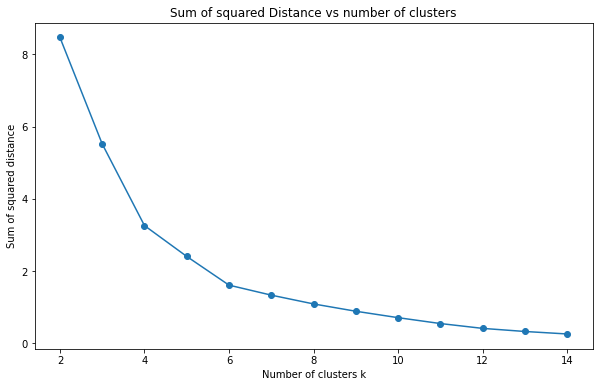

In [104]:
Dhaka_grouped_clustering = Dhaka_grouped.drop(['Neighborhood'], axis=1)
sse = []
list_k = list(range(2, 15))

for k in list_k:
    km = KMeans(n_clusters=k,n_init=1000,max_iter=10000,random_state=0).fit(Dhaka_grouped_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(10, 6))
plt.plot(list_k, sse, '-o')
plt.title('Sum of squared Distance vs number of clusters')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distance')

## K mean clustering

In [167]:
# # set number of clusters
kclusters = 7

# # run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4,n_init=1000,max_iter=1000).fit(Dhaka_grouped_clustering)

# # check cluster labels generated for each row in the dataframe
kmeans.labels_

(unique, counts) = np.unique(kmeans.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[ 0  4]
 [ 1 14]
 [ 2  3]
 [ 3 10]
 [ 4  1]
 [ 5  5]
 [ 6  2]]


## Final Dataset

Now lets create a data set with all the most common items as well as the clusterlabels, thana, suboffice, post code, and lattitude longitude

In [135]:
neighborhoods_venues_sorted['Cluster Labels']=pd.DataFrame(kmeans.labels_)

neighborhoods_venues_sorted['Latitude']=''
neighborhoods_venues_sorted['Longitude']=''
neighborhoods_venues_sorted['Thana']=''
neighborhoods_venues_sorted['Post Code']=''

for index_a,Neighborhood in enumerate(neighborhoods_venues_sorted['Neighborhood']):
    for index_b,SubOffice in enumerate(Dhaka_loc['SubOffice']):
         if Neighborhood==SubOffice:
             #print(index_a,index_b,Neighborhood,Dhaka_loc.iloc[index_b,1])
             neighborhoods_venues_sorted.loc[index_a,'Post Code']=Dhaka_loc.loc[index_b,'Post Code']
             neighborhoods_venues_sorted.loc[index_a,'Latitude']=Dhaka_loc.loc[index_b,'Latitude']
             neighborhoods_venues_sorted.loc[index_a,'Thana']=Dhaka_loc.loc[index_b,'Thana']
             neighborhoods_venues_sorted.loc[index_a,'Longitude']=Dhaka_loc.loc[index_b,'Longitude']
Dhaka_clustered=neighborhoods_venues_sorted.copy(deep= True)
Dhaka_clustered.columns


column_names = ['Thana','Neighborhood', 'Post Code',
            'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
            '3rd Most Common Venue', '4th Most Common Venue',
            '5th Most Common Venue', '6th Most Common Venue',
            '7th Most Common Venue', '8th Most Common Venue',
            '9th Most Common Venue', '10th Most Common Venue','Latitude', 'Longitude']

Dhaka_clustered = Dhaka_clustered.reindex(columns=column_names)
Dhaka_clustered.sort_values(by=['Cluster Labels'],inplace=True)
Dhaka_clustered.head()

,Thana,Neighborhood,Post Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
19,Keraniganj,Kalatia,1313,0,American Restaurant,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.6982,90.3505
1,Keraniganj,Ati,1312,0,American Restaurant,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.6982,90.3505
21,Keraniganj,Keraniganj,1310,0,American Restaurant,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.6982,90.3505
8,Keraniganj,Dhaka Jute Mills,1311,0,American Restaurant,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.6982,90.3505
23,Khilkhet,KhilkhetTSO,1229,1,Shopping Mall,Lounge,Coffee Shop,Hookah Bar,Indian Restaurant,Tea Room,Clothing Store,Gymnastics Gym,Light Rail Station,Bar,23.8307,90.4236


In [0]:
Dhaka_clustered.to_csv('Dhaka_clustered.csv',index=False)

## Map of clustered location

Now lets map the locations having same cluster labels.

In [136]:
# create map for dhaka
map_clusters = folium.Map(location=[23.8103, 90.4125], zoom_start=12.2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map'Latitude','Longitude'],
markers_colors = []
#ghapla
for lat, lon, poi, cluster in zip(Dhaka_clustered['Latitude'], 
                                  Dhaka_clustered['Longitude'], 
                                  Dhaka_clustered['Thana'], 
                                  Dhaka_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-3],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Areas based on clusters
lets now create individual dataframes based on clusters

CLuster 0 is in Thana Keraniganj with Ati, Keraniganj, Dhaka Jute mills, and kalatia locations which have common attributes within but they have distinct difference with other clusters. the most common resturent categories for this cluster is american and Turkish resturents. They also have cricket ground Department store farmers market within 1.5 KM range.

In [144]:
Cluster_0=Dhaka_clustered[Dhaka_clustered['Cluster Labels']==0]
Cluster_0.to_csv('Cluster_0.csv',index=False)
Cluster_0.head()

,Thana,Neighborhood,Post Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
19,Keraniganj,Kalatia,1313,0,American Restaurant,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.6982,90.3505
1,Keraniganj,Ati,1312,0,American Restaurant,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.6982,90.3505
21,Keraniganj,Keraniganj,1310,0,American Restaurant,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.6982,90.3505
8,Keraniganj,Dhaka Jute Mills,1311,0,American Restaurant,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.6982,90.3505


CLuster 1 consists of 11 Thanas. They are Gulshan, Mohammadpur, Khilkhet, Uttara, Khilgaon, Ramna,Tejgaon, Dahka sadarm Dhanmondi, shabujbag and Mirpur.
we have analyzed 14 neighborhoods in this area. they are Khilkhet-TSO, Khilgaon-TSO, Uttara Model Town-TSO, Jigatala TSO, Gulshan Model Town, Sangsad Bhaban TSO, Mirpur TSO, Mohammadpur Housing, Shantinagr TSO, Dhaka Cantonment TSO, Basabo TSO, Tejgaon TSO, Banani TSO, and Badda.

the most common item in these areas are Café, Fast Food Restaurant, Shopping Mall, and Hotel.


In [177]:
Cluster_1=Dhaka_clustered[Dhaka_clustered['Cluster Labels']==1]
Cluster_1.to_csv('Cluster_1.csv',index=False)
Cluster_1.head()

,Thana,Neighborhood,Post Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
23,Khilkhet,KhilkhetTSO,1229,1,Shopping Mall,Lounge,Coffee Shop,Hookah Bar,Indian Restaurant,Tea Room,Clothing Store,Gymnastics Gym,Light Rail Station,Bar,23.8307,90.4236
22,Khilgaon,KhilgaonTSO,1219,1,Fast Food Restaurant,Shopping Mall,Café,Indian Restaurant,Plaza,Market,Coffee Shop,Light Rail Station,Lake,Comfort Food Restaurant,23.7497,90.4176
37,Uttara,Uttara Model TownTSO,1230,1,Mexican Restaurant,Café,Department Store,Pizza Place,Restaurant,Ice Cream Shop,Asian Restaurant,BBQ Joint,Bakery,Market,23.8755,90.3996
16,Dhanmondi,Jigatala TSO,1209,1,Café,Fast Food Restaurant,Restaurant,Shopping Mall,Bakery,Ice Cream Shop,Coffee Shop,Art Gallery,Asian Restaurant,Bus Station,23.7471,90.3757
14,Gulshan,Gulshan Model Town,1212,1,Café,Hotel,Coffee Shop,Korean Restaurant,Asian Restaurant,Fast Food Restaurant,Italian Restaurant,Indian Restaurant,Nightclub,Ice Cream Shop,23.79,90.4116


in this study,Cluster_2 consist of one thana, Jaypara, with three neighborhood Joypara, Palamganj, and Narisha. The most common items in this location are Big Box store, Turkish Resturent and Fried Chicken Joint.

In [179]:
Cluster_2=Dhaka_clustered[Dhaka_clustered['Cluster Labels']==2]
Cluster_2.to_csv('Cluster_2.csv',index=False)
Cluster_2

,Thana,Neighborhood,Post Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
17,Joypara,Joypara,1331,2,Big Box Store,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.6076,90.125
27,Joypara,Palamganj,1331,2,Big Box Store,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.6076,90.125
26,Joypara,Narisha,1332,2,Big Box Store,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.6076,90.125


in this study, Cluster_3 consist of one thana, Savar, with ten neighborhoods Amin Bazar, Dairy Farm, Saver P.A.T.C, Rajphulbaria, EPZ, Kashem Cotton Mills, Jahangirnagar University, Savar Canttonment, Savar, and Shimulia. The most common items in this location are Shopping mall, Bus station and market

In [186]:
Cluster_3=Dhaka_clustered[Dhaka_clustered['Cluster Labels']==3]
Cluster_3.to_csv('Cluster_3.csv',index=False)
Cluster_3.head()

,Thana,Neighborhood,Post Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
33,Savar,Saver P.A.T.C,1343,3,Shopping Mall,Bus Station,Market,Turkish Restaurant,Food,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,23.8477,90.2587
29,Savar,Rajphulbaria,1347,3,Shopping Mall,Bus Station,Market,Turkish Restaurant,Food,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,23.8477,90.2587
35,Savar,Shimulia,1345,3,Shopping Mall,Bus Station,Market,Turkish Restaurant,Food,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,23.8477,90.2587
32,Savar,Savar Canttonment,1344,3,Shopping Mall,Bus Station,Market,Turkish Restaurant,Food,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,23.8477,90.2587
31,Savar,Savar,1340,3,Shopping Mall,Bus Station,Market,Turkish Restaurant,Food,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,23.8477,90.2587


The Dhamrai thana's Kalampur is a cluster of its own, we can say this is an anomaly. the most common item of kalampur is market, Turkish Resturent and fried chicken joint. 

In [187]:
Cluster_4=Dhaka_clustered[Dhaka_clustered['Cluster Labels']==4]
Cluster_4.to_csv('Cluster_4.csv',index=False)
Cluster_4

,Thana,Neighborhood,Post Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
18,Dhamrai,Kalampur,1351,4,Market,Turkish Restaurant,Fried Chicken Joint,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,23.9202,90.2109


Cluster 5 is a little different it has some of historical site. We call this cluster old dhaka. It consists of Lalbag, Sutrapur, Motijheel and Jatrabari thana. The neighborhoods analyzed are Posta, Gandaria, Dilkusha, Dhania and Bangabhaban. The most common items in this cluster are train station, resturent and historic Site. 

In [194]:
Cluster_5=Dhaka_clustered[Dhaka_clustered['Cluster Labels']==5]
Cluster_5.to_csv('Cluster_5.csv',index=False)
Cluster_5.head()

,Thana,Neighborhood,Post Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
28,Lalbag,Posta TSO,1211,5,Historic Site,Pizza Place,Restaurant,Asian Restaurant,Turkish Restaurant,Fast Food Restaurant,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,23.7188,90.3882
13,Sutrapur,Gandaria TSO,1204,5,Train Station,Fast Food Restaurant,Restaurant,Outlet Store,Boat or Ferry,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,23.6994,90.4242
11,Motijheel,DilkushaTSO,1223,5,Restaurant,Hotel,Plaza,Soccer Field,Train Station,Fried Chicken Joint,Cosmetics Shop,Clothing Store,Bus Station,Indian Restaurant,23.7266,90.4216
10,Jatrabari,Dhania TSO,1236,5,Train Station,Intersection,Bus Station,Playground,Food,Cricket Ground,Dentist's Office,Department Store,Dessert Shop,Donut Shop,23.7104,90.4345
4,Motijheel,BangabhabanTSO,1222,5,Restaurant,Hotel,Plaza,Soccer Field,Train Station,Fried Chicken Joint,Cosmetics Shop,Clothing Store,Bus Station,Indian Restaurant,23.7266,90.4216


Cluster 6 has two neighborhoods and they are both from sutrapur thana, they are Dhaka sadar and wari. the most common item in this cluster in food resturent.

In [195]:
Cluster_6=Dhaka_clustered[Dhaka_clustered['Cluster Labels']==6]
Cluster_6.to_csv('Cluster_6.csv',index=False)
Cluster_6

,Thana,Neighborhood,Post Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
9,Sutrapur,Dhaka Sadar HO,1100,6,Comfort Food Restaurant,Asian Restaurant,Turkish Restaurant,Fried Chicken Joint,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,24.0799,90.1866
38,Sutrapur,Wari TSO,1203,6,Comfort Food Restaurant,Asian Restaurant,Turkish Restaurant,Fried Chicken Joint,Dentist's Office,Department Store,Dessert Shop,Donut Shop,Electronics Store,Farmers Market,24.0799,90.1866


## Results and Discussion <a name="results"></a>

Our analysis shows clusters of the similer locations in Dhaka bangladesh. based on their distinctive venue categories. We have used 1000 maxim iterations for the k mean algorithm and the SSE is bellow 1. So we can say that the clusters are of accepctable accuracy.

some clusters have values everything in common. this maybe possible due to having same lattitude and lognitude or the range is high. so the forsquare api listed same items and they were sorted into same cluster. This project doesn't show any visualization maybe in future I will learn more and create more promising projects to show case.

## Conclusion <a name="conclusion"></a>

the perpose of this project was to do everything a data scientist does everyday in his life. The project gives enough opportunity to lean and exercise exciting new things. though this project is not impactful enough, it is a start. I want to thank IBM and Coursera to bring such a good course for learnign data science.